# GANs

Use the "Run" button to execute the code.

In [2]:
!pip install jovian --upgrade --quiet

In [4]:
import jovian

In [5]:
# Execute this to save new versions of the notebook
jovian.commit(project="gan")

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/noumanamir453/gan


'https://jovian.ai/noumanamir453/gan'

In [6]:
!pip install opendatasets --upgrade --quiet

In [7]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: noumanamir
Your Kaggle Key: ··········


  0%|          | 0.00/395M [00:00<?, ?B/s]

100%|██████████| 395M/395M [00:10<00:00, 39.7MB/s]


In [8]:
import os

DATA_DIR = './animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [10]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [11]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [12]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

# Helper Functions

In [14]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [15]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


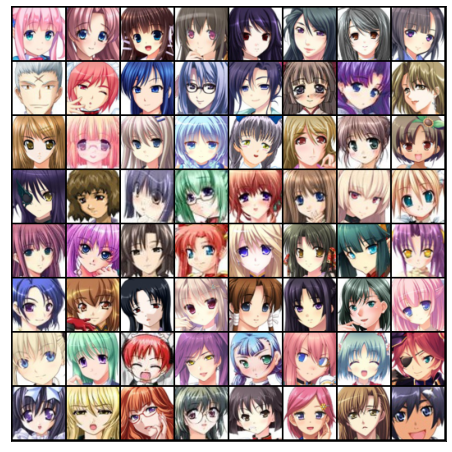

In [16]:
show_batch(train_dl)

# Using a GPU

In [17]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [18]:
device = get_default_device()
device

device(type='cuda')

In [19]:
train_dl = DeviceDataLoader(train_dl, device)

# Discriminator Network

In [20]:
import torch.nn as nn

In [21]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [22]:
discriminator = to_device(discriminator, device)

# Generator Network

In [23]:
latent_size = 128

In [24]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [25]:
generator = to_device(generator, device)

# Discriminator Training

In [26]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

# Generator Training

In [27]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [28]:
from torchvision.utils import save_image

In [29]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [30]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [36]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

# Full Training Loop

In [31]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [32]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [33]:
lr = 0.0002
epochs = 30

In [34]:
jovian.reset()
jovian.log_hyperparams(lr=lr, epochs=epochs)

[jovian] Hyperparams logged.


In [37]:
history = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/25], loss_g: 5.3983, loss_d: 0.3698, real_score: 0.7668, fake_score: 0.0244
Saving generated-images-0001.png



Epoch [2/25], loss_g: 4.4500, loss_d: 0.1502, real_score: 0.9066, fake_score: 0.0362
Saving generated-images-0002.png



Epoch [3/25], loss_g: 7.0987, loss_d: 0.2745, real_score: 0.8053, fake_score: 0.0062
Saving generated-images-0003.png



Epoch [4/25], loss_g: 6.1852, loss_d: 0.1209, real_score: 0.9035, fake_score: 0.0124
Saving generated-images-0004.png



Epoch [5/25], loss_g: 7.0016, loss_d: 0.0332, real_score: 0.9903, fake_score: 0.0224
Saving generated-images-0005.png



Epoch [6/25], loss_g: 9.4263, loss_d: 0.0392, real_score: 0.9677, fake_score: 0.0026
Saving generated-images-0006.png



Epoch [7/25], loss_g: 3.9860, loss_d: 0.0791, real_score: 0.9780, fake_score: 0.0507
Saving generated-images-0007.png



Epoch [8/25], loss_g: 6.7215, loss_d: 0.0420, real_score: 0.9853, fake_score: 0.0261
Saving generated-images-0008.png



Epoch [9/25], loss_g: 5.6532, loss_d: 0.5653, real_score: 0.9999, fake_score: 0.2893
Saving generated-images-0009.png



Epoch [10/25], loss_g: 10.3851, loss_d: 0.2336, real_score: 0.9576, fake_score: 0.1400
Saving generated-images-0010.png



Epoch [11/25], loss_g: 5.7202, loss_d: 0.0368, real_score: 0.9828, fake_score: 0.0170
Saving generated-images-0011.png



Epoch [12/25], loss_g: 5.7087, loss_d: 0.1489, real_score: 0.9316, fake_score: 0.0478
Saving generated-images-0012.png



Epoch [13/25], loss_g: 8.0861, loss_d: 0.1138, real_score: 0.9870, fake_score: 0.0898
Saving generated-images-0013.png



Epoch [14/25], loss_g: 4.6877, loss_d: 0.1082, real_score: 0.9414, fake_score: 0.0327
Saving generated-images-0014.png



Epoch [15/25], loss_g: 10.1335, loss_d: 0.2235, real_score: 0.9722, fake_score: 0.1619
Saving generated-images-0015.png



Epoch [16/25], loss_g: 4.9701, loss_d: 0.0886, real_score: 0.9654, fake_score: 0.0148
Saving generated-images-0016.png



Epoch [17/25], loss_g: 14.0338, loss_d: 0.0627, real_score: 0.9816, fake_score: 0.0358
Saving generated-images-0017.png



Epoch [18/25], loss_g: 6.1631, loss_d: 0.0852, real_score: 0.9486, fake_score: 0.0086
Saving generated-images-0018.png



Epoch [19/25], loss_g: 7.4484, loss_d: 0.1228, real_score: 0.9801, fake_score: 0.0840
Saving generated-images-0019.png



Epoch [20/25], loss_g: 3.9313, loss_d: 0.1916, real_score: 0.9056, fake_score: 0.0231
Saving generated-images-0020.png



Epoch [21/25], loss_g: 6.1259, loss_d: 0.1113, real_score: 0.9364, fake_score: 0.0227
Saving generated-images-0021.png



Epoch [22/25], loss_g: 6.0188, loss_d: 0.1022, real_score: 0.9582, fake_score: 0.0390
Saving generated-images-0022.png



Epoch [23/25], loss_g: 11.2444, loss_d: 0.0694, real_score: 0.9500, fake_score: 0.0003
Saving generated-images-0023.png



Epoch [24/25], loss_g: 5.8053, loss_d: 0.1093, real_score: 0.9268, fake_score: 0.0110
Saving generated-images-0024.png



Epoch [25/25], loss_g: 5.5586, loss_d: 0.0602, real_score: 0.9824, fake_score: 0.0395
Saving generated-images-0025.png


In [38]:
losses_g, losses_d, real_scores, fake_scores = history

In [39]:
jovian.log_metrics(loss_g=losses_g[-1], 
                   loss_d=losses_d[-1], 
                   real_score=real_scores[-1], 
                   fake_score=fake_scores[-1])

[jovian] Metrics logged.


In [40]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [44]:
from IPython.display import Image

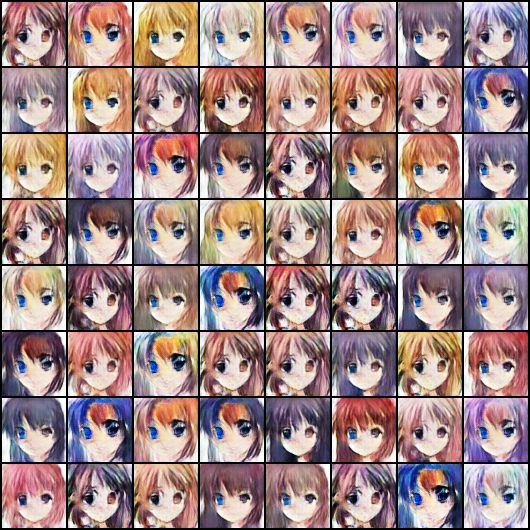

In [48]:
Image('./generated/generated-images-0022.png')

In [41]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [42]:
jovian.commit(project="gan", 
              outputs=['G.pth', 'D.pth', 'gans_training.avi'], 
              environment=None)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
Committed successfully! https://jovian.ai/noumanamir453/gan


'https://jovian.ai/noumanamir453/gan'